/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/lib/python2.7/dist-packages/matplotlib/__init__.py:1359: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


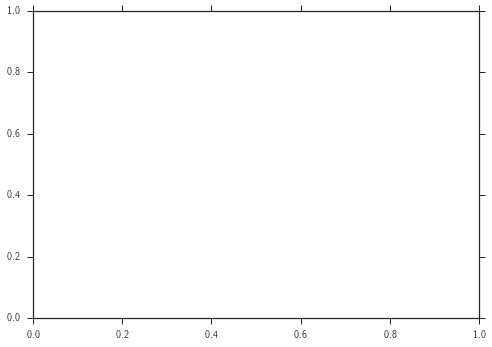

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
import imp
import sys
sys.path.insert(0,'/home/robin/Projects/INM6/elephant')
sys.path.append('/home/robin/Projects/INM6/python-neo')
sys.path.append('/home/robin/Projects/simrest_validation')
sys.path.append('/home/robin/Projects/INM6/Tasks/')
from viziphant.plots.rasterplot import rasterplot
from elephant.spike_train_surrogates import * 
from elephant.statistics import mean_firing_rate, cv, isi
from validation.matrix import eigenvalue_significance, plot_EVs
from validation.matrix import corr_matrix, plot_matrix, reorder_matrix
from scipy.linalg import eigh
from networkunit import models, tests, scores
from networkunit.plots import alpha
import seaborn as sns
from quantities import Hz, ms
from scipy.linalg import eigh
from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('http://bit.ly/1Bf5Hft').read())
rc('text', usetex=True)
font_size = 24
text_size = 26

## Test Network

In [2]:
size = 100
rate = 10*Hz
tstart = 0*ms
tstop = 10000*ms
binsize = 2*ms

model_HPP = models.stochastic_activity(size=size, correlations=0, assembly_sizes=[],
                                correlation_method='HPP', t_start=tstart, t_stop=tstop,
                                shuffle=False, name='A', color=sns.color_palette('Set2')[2])

/usr/local/lib/python2.7/dist-packages/quantities/quantity.py:321: RuntimeWarning: divide by zero encountered in true_divide
  return np.true_divide(other, self)


## Eigenvalue analysis

In [6]:
cc_matrix = corr_matrix(model_HPP.spiketrains)
EWs, EVs = eigh(cc_matrix)

1.30302349046

Significance Test:
	Method: SCREE 
	3 of 100 eigenvalues are significant

Princial components:
	0: 1.30
	1: 1.29
	2: 1.27



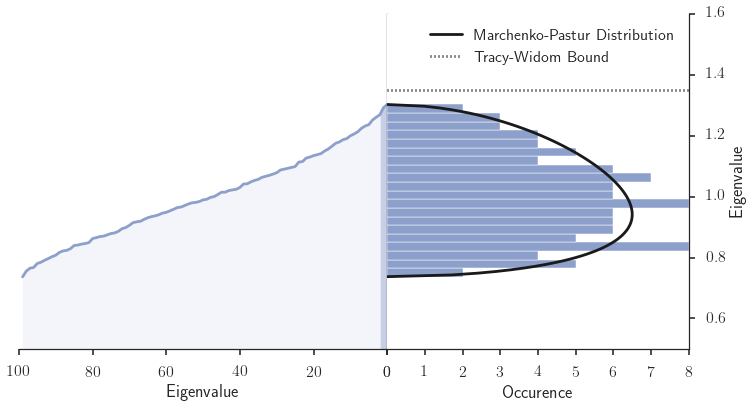

In [4]:
sns.set(style='ticks', palette='Set2', context='poster')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))

print max(EWs)

eigenvalue_significance(EWs, ax=ax, bins=20, N=size, 
                        B=float((tstop-tstart)/binsize),
                        ylim=(.5, 1.6),
                        color=sns.color_palette('Set2')[2]);

ax.set_xlabel('Eigenvalue \#')

# plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/ew_dist_hpp.png')

## Spectral Norm

In [71]:
from scipy.stats import zscore

trial_num = 1
l_max = np.zeros(trial_num)

for t in range(trial_num):
#     model_HPP = models.stochastic_activity(size=100, correlations=0, assembly_sizes=[],
#                                     correlation_method='HPP', t_start=tstart, t_stop=tstop, rate=10*Hz,
#                                     shuffle=False, name='A', color=sns.color_palette('Set2')[2])

#     cc_matrix = corr_matrix(model_HPP.spiketrains)
    r_mat = np.random.randint(0,2,(100,100))
    for i in range(100):
        r_mat[i] = zscore(r_mat[i]) 
#     r_mat[i] /= np.linalg.norm(r_mat[i])
    cc_matrix = np.dot(r_mat,r_mat.T) / 100.
    np.fill_diagonal(cc_matrix, 1)
    EWs, EVs = eigh(cc_matrix)
    l_max[t] = max(EWs)
    print cc_matrix.shape
    print cc_matrix

(100, 100)
[[ 1.   -0.25 -0.25 ..., -0.17  0.19  0.02]
 [-0.25  1.    0.19 ...,  0.19 -0.19  0.12]
 [-0.25  0.19  1.   ...,  0.19 -0.16 -0.02]
 ..., 
 [-0.17  0.19  0.19 ...,  1.   -0.17 -0.03]
 [ 0.19 -0.19 -0.16 ..., -0.17  1.    0.04]
 [ 0.02  0.12 -0.02 ..., -0.03  0.04  1.  ]]


In [72]:
print max(l_max), min(l_max)
print np.mean(l_max)

19.0420566268 19.0420566268
19.0420566268


## Eigenvectors


In [15]:
from neo.core import SpikeTrain
size = 100
A = 5
cc = .2
rate = 10*Hz
tstart = 0*ms
tstop = 10000*ms
binsize = 2*ms

model_cpp = models.stochastic_activity(size=size, correlations=cc, assembly_sizes=[A],
                                correlation_method='CPP', t_start=tstart, t_stop=tstop,
                                shuffle=False)

# test_st = SpikeTrain(np.array(model_cpp.spiketrains[0].tolist())+2, units='ms', 
#                      t_start=tstart, t_stop=tstop)
# model_cpp.spiketrains = model_cpp.spiketrains + [test_st]

In [16]:
cc_matrix = corr_matrix(model_cpp.spiketrains)
EWs, EVs = eigh(cc_matrix)

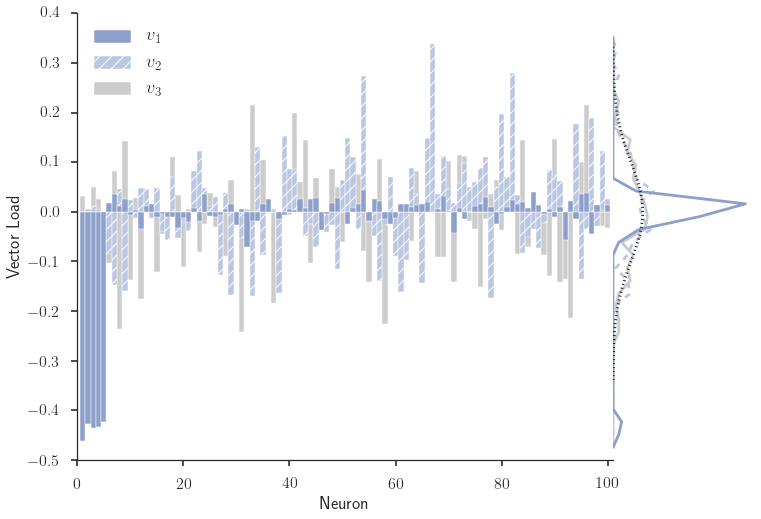

In [17]:
from matplotlib import rc
rc('text', usetex=True)
sns.set(style='ticks', palette='Set2', context='poster')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,8), sharex=True)
palette = sns.color_palette('Set2')

plot_EVs(EVs, ax, [palette[2], alpha(palette[2],0.6), '0.8'], ['', '//', ''], scaling=.8)

# plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/ev_loads.png')

## Assembly reconstruction

In [74]:
size = 100
A = [5,10,5]
cc = [.4,.3,.2]
rate = 10*Hz
tstart = 0*ms
tstop = 10000*ms
binsize = 2*ms

model_cpp = models.stochastic_activity(size=size, correlations=cc, assembly_sizes=A,
                                correlation_method='CPP', t_start=tstart, t_stop=tstop,
                                shuffle=True)

In [75]:
cpp_mat = corr_matrix(model_cpp.spiketrains, binsize=binsize)

EWs, EVs = eigh(cpp_mat)
order = reorder_matrix(EVs, EWs, alpha=0.001)

19
100


[]

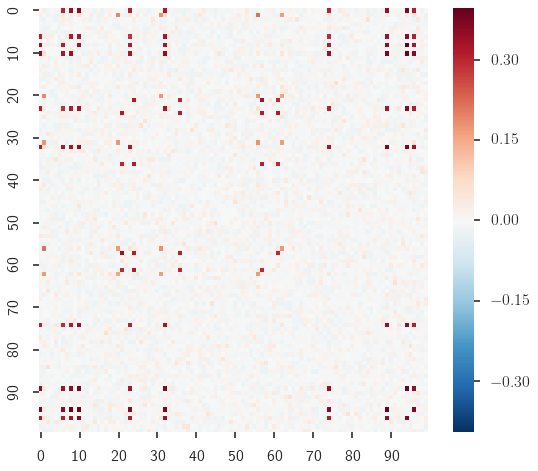

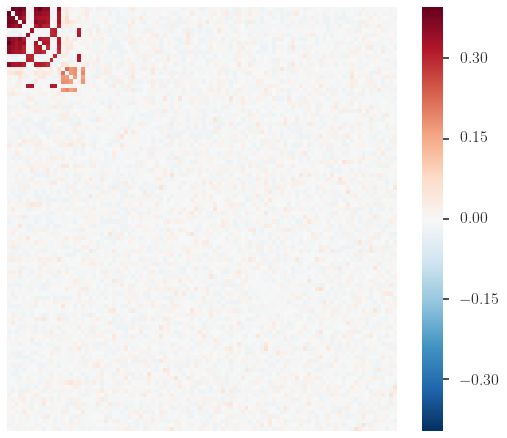

In [76]:
sns.set(style='ticks', palette='Set2', context='poster')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,7))
fig.tight_layout()

plot_matrix(cpp_mat, ax=ax, remove_autocorr=True)
# plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/ordered_ccmatrix_pre.png')

sns.set(style='ticks', palette='Set2', context='poster')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,7))
fig.tight_layout()

plot_matrix(cpp_mat[order,:][:,order], ax=ax, remove_autocorr=True)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
# plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/ordered_ccmatrix_post.png')

## Angles

In [239]:
size = 100
A = []
cc = .0
rate = 10*Hz
tstart = 0*ms
tstop = 10000*ms
binsize = 2*ms

model_A = models.stochastic_activity(size=size, correlations=cc, assembly_sizes=A,
                                correlation_method='CPP', t_start=tstart, t_stop=tstop,
                                shuffle=False)
model_B = models.stochastic_activity(size=size, correlations=cc, assembly_sizes=A,
                                correlation_method='CPP', t_start=tstart, t_stop=tstop,
                                shuffle=False)

In [242]:
matA = corr_matrix(model_A.spiketrains, binsize=binsize)
matB = corr_matrix(model_B.spiketrains, binsize=binsize)

_, EVs_A = eigh(matA)
_, EVs_B = eigh(matB)

EVs_A = EVs_A.T[::-1]
EVs_B = EVs_B.T[::-1]

flip = True

if flip:
    for count, ev in enumerate(EVs_A):
        EVs_A[count] = ev * np.sign(ev[np.argmax(np.absolute(ev))])
    for count, ev in enumerate(EVs_B):
        EVs_B[count] = ev * np.sign(ev[np.argmax(np.absolute(ev))])
    
M = np.dot(EVs_A, EVs_B.T)
ev_angles = [np.arccos(M.flatten())]
# ev_angles = [np.arccos(np.diag(M))]

In [72]:
res = 10000
angles = np.linspace(0,np.pi,res)
dist = np.array([np.sin(a)**(size-2) for a in angles])
dist = dist / (np.sum(dist) * np.pi/res)

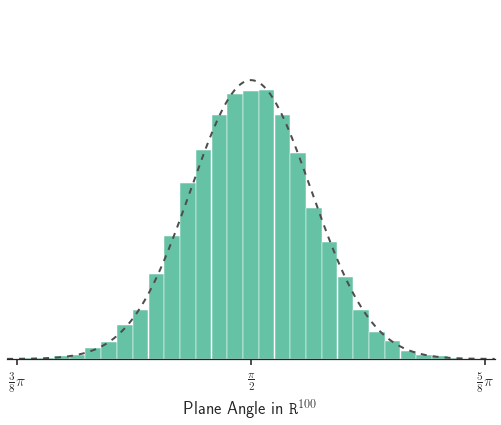

In [243]:
sns.set(style='ticks', palette='Set2', context='poster')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
plt.tight_layout()

ax.plot(angles, dist, color='0.3', lw=2, ls='--', label=r'$\sin^{}\phi$'.format('{'+str(size-2)+'}'))

edges = np.linspace(0,np.pi,120)
hist, _ = np.histogram(ev_angles, bins=edges, density=True)
# hist_diag, _ = np.histogram(ev_angles_diag, bins=edges, density=True)

ax.bar(edges[:-1], hist, np.diff(edges)[0]*.99, color=sns.color_palette()[0], edgecolor='w', 
       label=r'$\angle (\mathbf{v}_i,\mathbf{w}_j)$' + r'$: i,j\in [1,{}]$'.format(str(size)))
# ax.bar(edges[:-1], hist_diag, np.diff(edges)*.9, color=sns.color_palette()[4], edgecolor='w')


ax.set_xticks(np.array([0, 0.125, .25, .375, .5, .625, .75, .875, 1])*np.pi)
ax.set_xticklabels(['', r'$\frac{\pi}{8}$', r'$\frac{\pi}{4}$',
                    r'$\frac{3}{8}\pi$', r'$\frac{\pi}{2}$',
                    r'$\frac{5}{8}\pi$', r'$\frac{3}{4}\pi$',
                    r'$\frac{7}{8}\pi$', r'$\pi$'])
ax.set_xlabel(r'Plane Angle in $\mathtt{R}$' + r'$^{}$'.format('{'+str(size)+'}'))
sns.despine()
if flip:
    ax.yaxis.set_ticklabels([])
    ax.yaxis.set_ticks([])
    sns.despine(left=True)
else:
    ax.set_ylabel('Angle Density', fontweight='bold')
ax.set_ylim((0,5))
frame = np.pi*0.13
ax.set_xlim((np.pi/2.-frame, np.pi/2.+frame))
if not flip:
    plt.legend()

plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/random_angle_distribution{}.png'\
            .format('_flipped' if flip else ''), bbox_inches='tight')

## Angles as distance measure

In [244]:
size = 100
A = [10,5]
cc = .5
rate = 10*Hz
tstart = 0*ms
tstop = 10000*ms
binsize = 2*ms

model_A = models.stochastic_activity(size=size, correlations=cc, assembly_sizes=A,
                                correlation_method='CPP', t_start=tstart, t_stop=tstop,
                                shuffle=False)
model_B = models.stochastic_activity(size=size, correlations=cc, assembly_sizes=A,
                                correlation_method='CPP', t_start=tstart, t_stop=tstop,
                                shuffle=False)


In [245]:
matA = corr_matrix(model_A.spiketrains, binsize=binsize)
matB = corr_matrix(model_B.spiketrains, binsize=binsize)

_, EVs_A = eigh(matA)
_, EVs_B = eigh(matB)

EVs_A = EVs_A.T[::-1]
EVs_B = EVs_B.T[::-1]

for count, ev in enumerate(EVs_A):
    EVs_A[count] = ev * np.sign(np.argmax(np.absolute(ev)))
for count, ev in enumerate(EVs_B):
    EVs_B[count] = ev * np.sign(np.argmax(np.absolute(ev)))
    
M = np.dot(EVs_A, EVs_B.T)
ev_angles = [np.arccos(M.flatten())]
# ev_angles = [np.arccos(np.diag(M))]

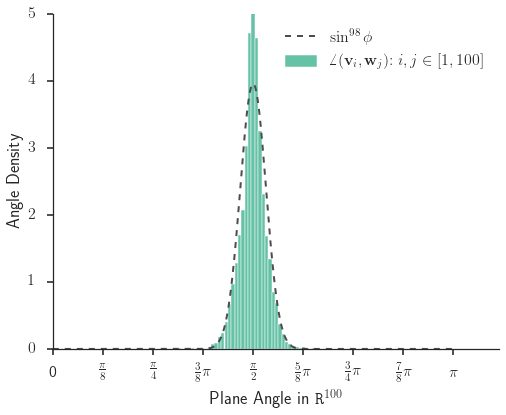

In [251]:
sns.set(style='ticks', palette='Set2', context='poster')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))

ax.plot(angles, dist, color='0.3', lw=2, ls='--', label=r'$\sin^{}\phi$'.format('{'+str(size-2)+'}'))

edges = np.linspace(0,np.pi,120)
hist, _ = np.histogram(ev_angles, bins=edges, density=True)
# hist_diag, _ = np.histogram(ev_angles_diag, bins=edges, density=True)

ax.bar(edges[:-1], hist, np.diff(edges)*.99, color=sns.color_palette()[0], edgecolor='w', 
       label=r'$\angle (\mathbf{v}_i,\mathbf{w}_j)$' + r'$: i,j\in [1,{}]$'.format(str(size)))
# ax.bar(edges[:-1], hist_diag, np.diff(edges)*.9, color=sns.color_palette()[4], edgecolor='w')


ax.set_xticks(np.array([0, 0.125, .25, .375, .5, .625, .75, .875, 1])*np.pi)
ax.set_xticklabels(['0', r'$\frac{\pi}{8}$', r'$\frac{\pi}{4}$',
                    r'$\frac{3}{8}\pi$', r'$\frac{\pi}{2}$',
                    r'$\frac{5}{8}\pi$', r'$\frac{3}{4}\pi$',
                    r'$\frac{7}{8}\pi$', r'$\pi$'])
ax.set_xlabel(r'Plane Angle in $\mathtt{R}$' + r'$^{}$'.format('{'+str(size)+'}'))
sns.despine()
ax.set_ylim((0,5))
frame = np.pi*0.13
# ax.set_xlim((np.pi/2.-frame, np.pi/2.+frame))
log = False
if log:
    ax.set_yscale('log')
else:
    ax.set_ylabel('Angle Density', fontweight='bold')
    plt.legend()

plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/cluster_angle_distribution{}.png'\
            .format('_log' if log else ''), bbox_inches='tight')